# Overview:

UCL stands for UEFA Champions League. This is the biggest Title race in the club football. I have done a very deep analysis in [this notebook](https://www.kaggle.com/bakar31/ucl-stats-analysis). Feel free to check this out.What are we gonna do is to develop a model with the highest accuracy, precision and F1-score to predict the new season champion. But to predict we need current season's data like number of matches played, number of wins, number of losses, goal difference, how many goals scored etc. Let's build our model

# Table of Contents

* [EDA](https://www.kaggle.com/bakar31/ucl-stats-analysis)
* [Basic data Info](#Basic-info-about-data)
    - [Solve imbalance distribution problem](https://www.kaggle.com/bakar31/a-guide-to-imbalance-distribution-problem-in-ml)
* [Feature Enginnering](#Feature-Engineering)
* [Feature Selection](#Feature-Selection)
* [Solve Imbalance Problem](#Balancing-Imbalance-Distribution-Problem)
* [Modeling](#Modeling)
    - [Logistic Regression](#Logistic-Regression)
    - [KNN](#KNN)
    - [SVC](#SVC)
    - [Random Foresr](#Random-Forest)
    - [GradientBoost](#Gradient-Boost)
    - [LightBGM](#LightBGM)
* [Score Analysis](#Score-Analysis![4D6N2F.gif](attachment:db4a4db7-3598-4b17-8bce-8074b5bbc41e.gif))

### An upvote will be very appreciated 

In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the dataset
df = pd.read_csv('../input/ucl-statistics/ucl_stats.csv')

# Basic info about data

In [3]:
df.head()

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0


In [4]:
df.shape

(714, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            714 non-null    int64 
 1   team            714 non-null    object
 2   match_played    714 non-null    int64 
 3   wins            714 non-null    int64 
 4   draws           714 non-null    int64 
 5   losts           714 non-null    int64 
 6   goals_scored    714 non-null    int64 
 7   goals_conceded  714 non-null    int64 
 8   gd              714 non-null    int64 
 9   group_point     714 non-null    int64 
 10  champions       714 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 61.5+ KB


In [6]:
#let's see the descriptive statistics of th data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,714.0,2008.711485,7.340121,1993.0,2004.0,2009.0,2015.0,2020.0
match_played,714.0,7.673669,2.100880,6.0,6.0,6.0,8.0,13.0
wins,714.0,2.939776,2.316600,0.0,1.0,2.0,4.0,11.0
draws,714.0,1.844538,1.273169,0.0,1.0,2.0,3.0,7.0
losts,714.0,2.892157,1.234552,0.0,2.0,3.0,4.0,6.0
goals_scored,714.0,10.582633,6.979194,0.0,5.0,9.0,14.0,43.0
goals_conceded,714.0,10.443978,3.634080,2.0,8.0,10.0,13.0,24.0
gd,714.0,0.198880,7.573646,-22.0,-5.0,0.0,5.0,35.0
group_point,714.0,8.183473,4.192922,-8.0,5.0,8.0,11.0,18.0
champions,714.0,0.039216,0.194244,0.0,0.0,0.0,0.0,1.0


In [7]:
# check for null values
df.isna().sum()

year              0
team              0
match_played      0
wins              0
draws             0
losts             0
goals_scored      0
goals_conceded    0
gd                0
group_point       0
champions         0
dtype: int64

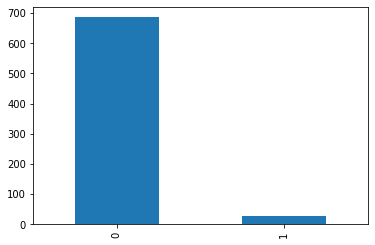

In [8]:
# number of sample in each class
df.champions.value_counts().plot(kind = 'bar');

We clearly dealing with Imbalance distribution problem. We must solve to get better model. Here is the [link](https://www.kaggle.com/bakar31/a-guide-to-imbalance-distribution-problem-in-ml) of a notebook in that I talked about various methods of balancing a dataet.

# Feature engineering

Feature engineerning is a very important and fruitful steps in every machine learning pipeline. Feature Enginnering enables us to create more powerful features from the existing feature that can help us making a better mode.

In [9]:
# new features
df['win_match_ratio'] = (df['wins'] + 1)/ df['match_played']
df['gs_match_ratio'] = (df['goals_scored'] + 1)/ df['match_played']
df['gc_match_ratio'] = (df['goals_conceded'] + 1)/ df['match_played']
df['win_gs_ratio'] = (df['wins'] + 1)/(df['goals_scored'] + 1)
df['win_lost_ratio'] = (df['wins'] + 1)/(df['losts'] + 1)
df['gs_gc'] = (df['goals_scored'] - df['goals_conceded']) + 0.1
df['wins_draws_ratio'] = (df['wins'] +  1) / (df['draws'] + 1)
df['gs_gd'] = (df['goals_scored'] + 1) + (df['gd'])

In [10]:
# dropping columns that are not important for the model.
df.drop(['year', 'team'], axis = 1, inplace = True)

In [11]:
# independent and dependent matrix of feature
x = df.drop('champions', axis = 1)
y = df['champions']

# Feature Selection

In [12]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [13]:
# mutual info regression scores
mi_score = make_mi_scores(x, y)
print(mi_score)

gs_gd               0.116323
match_played        0.094291
gs_gc               0.092128
win_lost_ratio      0.091640
gd                  0.075090
win_match_ratio     0.066035
goals_scored        0.057233
wins_draws_ratio    0.048086
losts               0.043858
wins                0.032409
gc_match_ratio      0.030865
group_point         0.029143
gs_match_ratio      0.011620
win_gs_ratio        0.010648
draws               0.000000
goals_conceded      0.000000
Name: MI Scores, dtype: float64


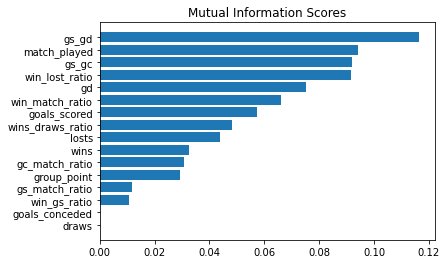

In [14]:
plot_mi_scores(mi_score)

# Balancing Imbalance Distribution Problem

In [15]:
# balancing the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_sm, y_sm= smote.fit_resample(x, y)

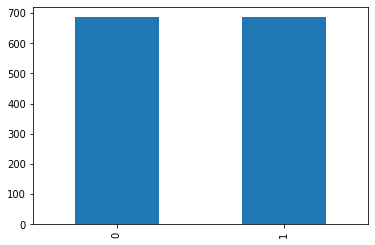

In [16]:
pd.DataFrame(y_sm).champions.value_counts().plot(kind = 'bar');

**Yay!** Our imbalance distribtion problem is solved.

In [17]:
# splitting into train and test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_sm, y_sm,random_state = 31)

In [18]:
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
def report(classifier, x_test = x_test, y_test = y_test):
    print("Classification Report: \n")
    y_preds = classifier.predict(x_test)
    print(classification_report(y_test, y_preds))
    print("Confusion Matrix: \n")
    plot_confusion_matrix(classifier, x_test, y_test, cmap=plt.cm.Blues)
    print("ROC: \n")
    plot_roc_curve(classifier, x_test, y_test) 
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Modeling

## Logistic Regression

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter = 100,
                             C = 5.428675439323859,
                             penalty='l1',
                             solver='liblinear',
                             random_state = 41).fit(x_train, y_train)

cv_lr = cross_val_score(log_clf, x_train, y_train, cv = 10)
lr_score = np.mean(cv_lr)
print("LR Score: ", lr_score)

LR Score:  0.9737673710260804


Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       174
           1       0.96      0.98      0.97       169

    accuracy                           0.97       343
   macro avg       0.97      0.97      0.97       343
weighted avg       0.97      0.97      0.97       343

Confusion Matrix: 

ROC: 



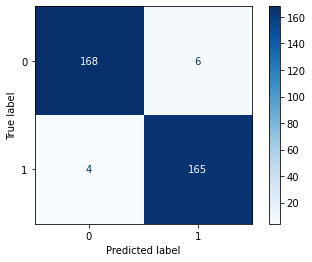

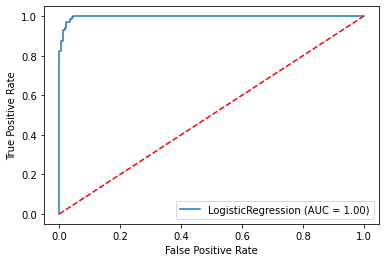

In [20]:
report(log_clf)

## KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# parameter tuned by gridsearchcv
knn_clf = KNeighborsClassifier(algorithm='auto',
                                leaf_size=10,
                                n_neighbors=2,
                                p = 1).fit(x_train, y_train)

cv_knn = cross_val_score(knn_clf, x_train, y_train, cv = 10)
knn_score = np.mean(cv_knn)
print("KNN Score: ", knn_score)

KNN Score:  0.9727679421283076


Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       174
           1       0.95      0.98      0.97       169

    accuracy                           0.97       343
   macro avg       0.97      0.97      0.97       343
weighted avg       0.97      0.97      0.97       343

Confusion Matrix: 

ROC: 



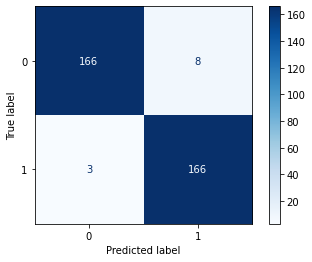

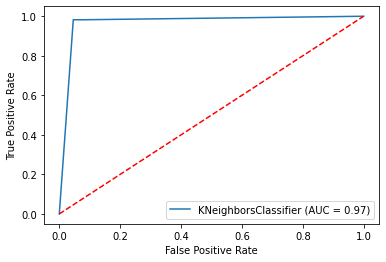

In [22]:
report(knn_clf)

# SVC

In [23]:
from sklearn import svm

# parameter tuned by gridsearchcv
svc_clf = svm.SVC(C = 233.57214690901213,
                  degree = 2,
                  kernel = 'rbf',
                  random_state = 7).fit(x_train, y_train)

cv_svc = cross_val_score(knn_clf, x_train, y_train, cv = 10)
svc_score = np.mean(cv_svc)
print("SVC Score: ", svc_score)

SVC Score:  0.9727679421283076


Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       174
           1       0.97      0.99      0.98       169

    accuracy                           0.98       343
   macro avg       0.98      0.98      0.98       343
weighted avg       0.98      0.98      0.98       343

Confusion Matrix: 

ROC: 



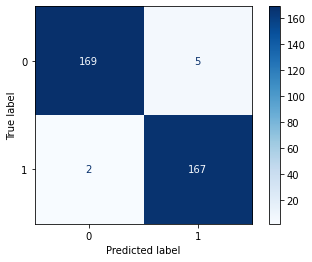

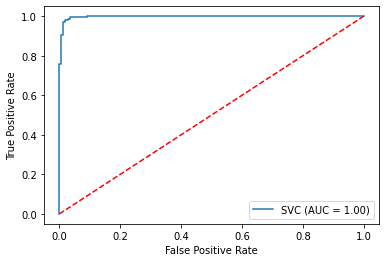

In [24]:
report(svc_clf)

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

# parameters were taken by randomizedsearchcv
rand_clf = RandomForestClassifier(n_estimators=1000,
                                 min_samples_split = 4,
                                 min_samples_leaf = 1,
                                 max_depth = None,
                                 random_state = 35).fit(x_train, y_train)

cv_rf = cross_val_score(rand_clf, x_train, y_train, cv = 10)
rf_score = np.mean(cv_rf)
print("RF Score: ", rf_score)

RF Score:  0.9747477631829431


Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       174
           1       0.95      0.98      0.96       169

    accuracy                           0.97       343
   macro avg       0.97      0.97      0.97       343
weighted avg       0.97      0.97      0.97       343

Confusion Matrix: 

ROC: 



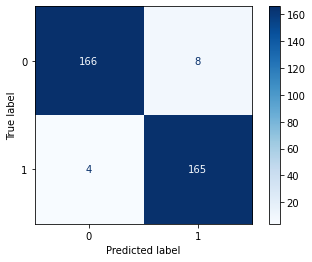

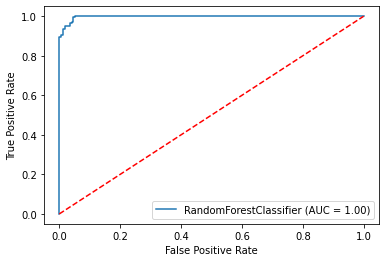

In [26]:
report(rand_clf)

# Gradient Boost

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_clf = GradientBoostingClassifier(learning_rate=0.1,
                                 loss='deviance',
                                 max_depth=2,
                                 min_samples_leaf=5,
                                 min_samples_split=2,
                                 n_estimators=500,
                                 random_state=31).fit(x_train, y_train)

cv_gbc = cross_val_score(gbc_clf, x_train, y_train, cv = 10)
gbc_score = np.mean(cv_gbc)
print("GBC Score: ", gbc_score)

GBC Score:  0.9844374643061109


Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       174
           1       0.96      0.98      0.97       169

    accuracy                           0.97       343
   macro avg       0.97      0.97      0.97       343
weighted avg       0.97      0.97      0.97       343

Confusion Matrix: 

ROC: 



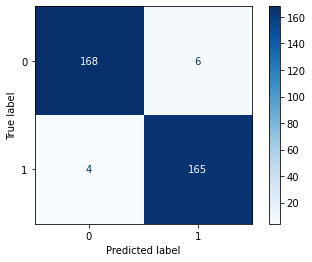

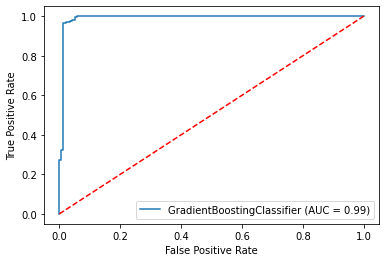

In [28]:
report(gbc_clf)

# LightBGM

In [29]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier().fit(x_train, y_train)
cv_lgbm = cross_val_score(lgbm, x_train, y_train, cv = 10)
lgbm_score = np.mean(cv_lgbm)
print("Lgbm Score: ", lgbm_score)

Lgbm Score:  0.9854178564629736


Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       174
           1       0.97      0.99      0.98       169

    accuracy                           0.98       343
   macro avg       0.98      0.98      0.98       343
weighted avg       0.98      0.98      0.98       343

Confusion Matrix: 

ROC: 



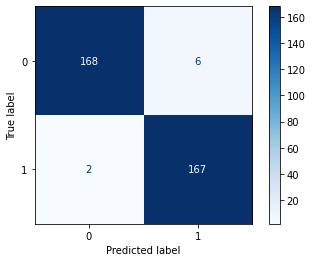

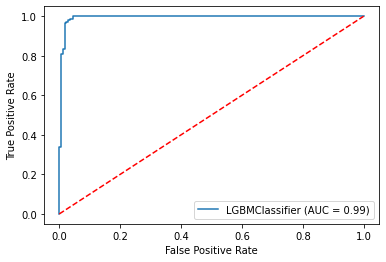

In [30]:
report(lgbm)

# Score Analysis

In [31]:
score_dict= {'Logistic Regression':lr_score,
             'KNN':knn_score,
             'SVC':svc_score,
             'Random Forest': rf_score,
             'Gradient Boost':gbc_score,
             'LightBGM':lgbm_score}
pd.DataFrame.from_dict(score_dict, orient = 'index', columns = ['Score'])

,Score
Logistic Regression,0.973767
KNN,0.972768
SVC,0.972768
Random Forest,0.974748
Gradient Boost,0.984437
LightBGM,0.985418
